**This code example creates a chatbot-like agent that involves a human in decision-making during the conversation.**
# . Introduction:
* Human-in-the-loop: This means that a human can approve or reject certain actions the chatbot wants to take, making the human a part of the decision-making process.
* ReAct Agent: A chatbot that can interact with tools (like searching the web) to respond to queries.
*Chat Executor: The base framework the chatbot operates within, where it processes inputs, decides on actions, and responds.

# Step 1: Install Necessary Packages
* This step installs the necessary Python packages: langgraph, langchain_community, langchain_openai, and tavily-python. These packages are essential for building the chatbot, integrating it with OpenAI, and using the Tavily search tool.


In [90]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_openai tavily-python

# Step 2: Set Up API Keys
 * In this step, we set up API keys for OpenAI and Tavily. The getpass.getpass function is used to securely input the API keys. These keys allow the chatbot to access OpenAI's language models and Tavily's search tool.

In [91]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

# Step 3: Set Up LangSmith API Key (Optional)
* This optional step sets up API keys for LangSmith tracing. This feature provides detailed observability and tracking for the chatbot's operations, helping in debugging and improving the bot's performance.

In [92]:
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="CourseLanggraph"

# Step 4: Define Tools
* Here, we define the tools the chatbot will use. Specifically, we import the Tavily search tool and configure it to return a maximum of one result. These tools enable the chatbot to perform searches on the web.

In [93]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

# Step 5: Initialize ToolExecutor
* his step initializes a ToolExecutor, a simple class that takes in a ToolInvocation and calls the corresponding tool. The ToolExecutor uses the tools we defined earlier to perform actions based on the chatbot's needs.

In [94]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

<ipython-input-94-fdad03f5602e>:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


# 4. Set Up the Model:
* Chat Model: You load a chat model from OpenAI that can handle message-based interactions and use OpenAI’s function-calling feature. This is important because the chatbot will interact with external tools like Tavily.
* Binding Tools to the Model: The tools are made available to the model so that it knows how to call them when needed.

# Step 6: Load OpenAI Model
* In this step, we load the OpenAI chat model that will power the chatbot. The model is set to stream responses token by token, making it more responsive. This model will interact with users and decide the actions the chatbot should take.

In [95]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)

# Step 7: Bind Tools to Model
* This step binds the previously defined tools (like Tavily search) to the OpenAI model. This allows the model to call these tools as part of its decision-making process.

In [96]:
model = model.bind_tools(tools)

# 8. Define the Agent State:
* This step defines the state the chatbot will track. The state is represented as a list of messages, and each new message will be added to this list. This helps in keeping track of the conversation and decisions made by the chatbot.



In [97]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

# Step 9: Define Core Functions
 This step defines key functions for the chatbot's operation:

* should_continue(state): Determines whether the chatbot should continue with the next action or stop.
* call_model(state): Calls the chat model with the current state and adds the response to the list of messages.


These functions are essential for guiding the chatbot's behavior based on user input and model responses.



In [98]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Step 10: Handle Tool Execution
* In this step, the chatbot handles the execution of tools when it decides to take action. It processes the tool invocations and adds the tool responses to the list of messages. This step allows the chatbot to perform tasks like web searches.


In [99]:
# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        ToolMessage(
            content=str(response),
            name=tc["name"],
            tool_call_id=tc["id"],
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # We return a list, because this will get added to the existing list
    return {"messages": tool_messages}

# Step 11: Define Workflow
* This step defines the overall workflow or graph that the chatbot will follow. The chatbot starts by calling the agent node (which invokes the model) and then decides whether to continue or stop. If it continues, it moves to the action node (which calls the tools). The process repeats until the chatbot decides to stop.

In [100]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=MemorySaver(), interrupt_before=["action"])

# Step 12: Visualize Workflow
* This optional step generates and displays a visual representation of the chatbot's workflow. It helps in understanding how the different nodes and edges are connected in the chatbot's decision-making process.



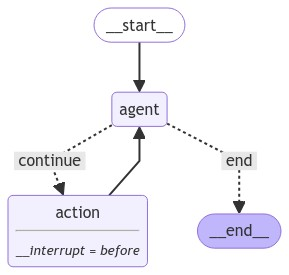

In [101]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Step 13: Execute Chatbot
* In this final step, the chatbot is executed, starting with an initial user input ("what is the weather in Pakistan"). The chatbot processes the input, calls the necessary tools, and asks for human approval before proceeding to the next step. The loop continues until the human decides to stop.

In [103]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in pakistan")]}
config = {"configurable": {"thread_id": "thread-1"}}
while True:
    for output in app.stream(inputs, config):
        # stream() yields dictionaries with output keyed by node name
        for key, value in output.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    snapshot = app.get_state(config)
    # If "next" is present, it means we've interrupted mid-execution
    if not snapshot.next:
        break
    inputs = None
    response = input(
        "Do you approve the next step? Type y if you do, anything else to stop: "
    )
    if response != "y":
        break

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_rfonN1upPcum2ZEbLKnc8jv0', 'function': {'arguments': '{"query":"weather in Pakistan"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-160a4bba-159c-4cee-8fb1-ee131e37f02c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Pakistan'}, 'id': 'call_rfonN1upPcum2ZEbLKnc8jv0', 'type': 'tool_call'}])]}

---



Do you approve the next step? Type y if you do, anything else to stop: y


<ipython-input-99-203961b373f3>:10: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(
<ipython-input-99-203961b373f3>:16: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


Output from node 'action':
---
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Islamabad\', \'region\': \'Islamabad\', \'country\': \'Pakistan\', \'lat\': 33.7, \'lon\': 73.17, \'tz_id\': \'Asia/Karachi\', \'localtime_epoch\': 1724586418, \'localtime\': \'2024-08-25 16:46\'}, \'current\': {\'last_updated_epoch\': 1724586300, \'last_updated\': \'2024-08-25 16:45\', \'temp_c\': 33.9, \'temp_f\': 93.1, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 2.7, \'wind_kph\': 4.3, \'wind_degree\': 270, \'wind_dir\': \'W\', \'pressure_mb\': 1001.0, \'pressure_in\': 29.55, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 47, \'cloud\': 13, \'feelslike_c\': 37.9, \'feelslike_f\': 100.2, \'windchill_c\': 33.9, \'windchill_f\': 93.1, \'heatindex_c\': 37.9, \'heatindex_f\': 100.2, \'dewpoint_c\': 21.0, \'dewpoint_f\': 69.8, \'vis_